https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf  
'Evidence' for KL divergence formula

In [1]:
import numpy as np

In [2]:
def relu(x, derivative = False):
    res = x
    if derivative == True:
        return (res > 0)*1
    else:
        return res * (res > 0)

def sigmoid(x, derivative = False):
    res = 1/(1 + np.exp(-x))
    if derivative == True:
        return res * (1 - res)
    else:
        return res

In [3]:
n_x = 30
m = 1000
l_1 = 10
n_z = 10 # Number of latent variables
alpha = 1e-7 # learning_rate

In [12]:
# Testing that everything works before converting to a class
np.random.seed(0)
train_inputs = np.random.randn(n_x, m)

W_1 = np.random.randn(l_1, n_x) * np.sqrt(2/n_x) # Kaiming initialization, encoder
b_1 = np.zeros(shape=(l_1, 1))

W_mu_1 = np.random.randn(n_z, l_1) * np.sqrt(2/l_1) # Kaiming initialization
b_mu_1 = np.zeros(shape = (n_z,1))

W_sigma_1 = np.random.randn(n_z, l_1) * np.sqrt(2/l_1) # Kaiming initialization
b_sigma_1 = np.zeros(shape = (n_z, 1))

eps = np.random.randn(n_z, m)

W_2 = np.random.randn(l_2, n_z) * np.sqrt(2/n_z) # Kaiming initialization, decoder
b_2 = np.zeros(shape = (l_2, 1))

W_mu_2 = np.random.randn(n_z, l_2) *np.sqrt(2/l_2) # Kaiming initialization
b_mu_2 = np.zeros(shape = (n_z, 1))

W_sigma_2 = np.random.randn(n_z, l_2) * np.sqrt(2/l_2)

# train_truth = (np.random.sample(size=(n_x,1)) >= 0.5)*1

losses_mse = []
losses_kl = []

for i in range(100):
    # Forward pass
    z_1 = W_1.dot(train_inputs) + b_1
    a_1 = relu(z_1)
    
    z_mu = W_mu.dot(a_1) + b_mu
    # There is no activation for mu layer
    z_sigma = W_sigma.dot(a_1) + b_sigma
    
    sampled_vector = z_mu + np.multiply(np.exp(z_sigma * 0.5), eps) # Elem-wise multiplication for eps and var.
    # Also treat z_sigma as a log-var instead, bypass the problem with negatives.
    
    z_2 = W_2.dot(sampled_vector) + b_2
    # Should there be a final activation? 
    # I don't think so - if we're going for MSE loss we're going to compare every single feature vector with the 
    # reconstructed one. So the range of the activation function has to be the whole real line, but most common ones
    # are not that way, like ReLU, tanh, sigmoid.
    
    # Loss - go with simple L2 loss
    loss_mse = np.mean(np.square(train_inputs - z_2))
    loss_kl = np.mean(np.sum(np.exp(z_sigma) + np.square(z_mu) - z_sigma - 0.5*np.ones(shape = z_sigma.shape),axis=1)) 
    loss = loss_mse + loss_kl
    
    losses_mse.append(loss_mse)
    losses_kl.append(loss_kl)
    # Warning - KL loss, taking mean is obscuring how some are close to N(0,1) and some are not.
    
    if i % 10 == 0:
        print('The loss from pass {} is: '.format(i) + str(loss))

    # Backward pass
    # Need one for W_1, b_1, W_mu, b_mu, W_sigma, b_sigma, W_2, b_2
    # This is for MSE loss
    grad_z_2 = -2 * (train_inputs - z_2) # (n_x, m)
    grad_W_2 = grad_z_2.dot(sampled_vector.T) # (n_z, m)
    grad_b_2 = (1/m) * np.sum(grad_z_2, keepdims = True)
    grad_s = W_2.T.dot(grad_z_2) # (n_z, m), gradient of sampled vector
    grad_z_mu = grad_s # (n_z, m)
    grad_z_sigma = np.multiply(grad_s, 0.5 * np.exp(z_sigma * 0.5) * eps)
    grad_W_mu = grad_z_mu.dot(a_1.T)
    grad_b_mu = (1/m) * np.sum(grad_z_mu, keepdims=True)
    grad_W_sigma = grad_z_sigma.dot(a_1.T)
    grad_b_sigma = (1/m) * np.sum(grad_z_sigma, keepdims=True)
    grad_a_1 = W_mu.T.dot(grad_z_mu)
    grad_z_1 = np.multiply(grad_a_1, relu(z_1, derivative=True))
    grad_b_1 = (1/m) * np.sum(grad_z_1, keepdims = True)
    grad_W_1 = grad_z_1.dot(train_inputs.T)
    
    # This is for KL loss
    grad_z_sigma += np.exp(z_sigma) - 1
    grad_z_mu += 2*z_mu # Seriously, wth. There is likely something from KL that can give intuition on this.
    grad_W_sigma += grad_z_sigma.dot(a_1.T)
    grad_b_sigma += (1/m) * np.sum(grad_z_sigma, keepdims = True)
    grad_W_mu += grad_z_mu.dot(a_1.T)
    grad_b_mu += (1/m) * np.sum(grad_z_mu, keepdims = True)
    
    # Do your gradient updates.
    b_2 -= alpha* grad_b_2
    W_2 -= alpha* grad_W_2
    b_mu -= alpha* grad_b_mu
    W_mu -= alpha* grad_W_mu
    b_sigma -= alpha* grad_b_sigma
    W_sigma -= alpha* grad_W_sigma
    b_1 -= alpha* grad_b_1
    W_1 -= alpha* grad_W_1

The loss from pass 0 is: 5768.286102241477
The loss from pass 10 is: 3767.1695248332862
The loss from pass 20 is: 3205.122711204208
The loss from pass 30 is: 2870.9948685936765
The loss from pass 40 is: 2638.4351401972453
The loss from pass 50 is: 2463.9544446587056
The loss from pass 60 is: 2327.001473964822
The loss from pass 70 is: 2216.15384107702
The loss from pass 80 is: 2124.3873556906774
The loss from pass 90 is: 2047.0887737703165


Text(0.5,1,'KL_loss')

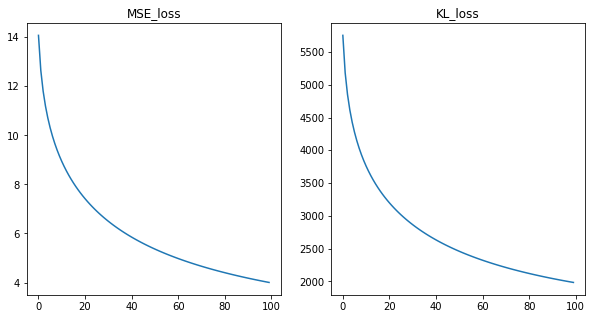

In [13]:
# Plot of losses
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.plot(losses_mse)
plt.title('MSE_loss')

plt.subplot(122)
plt.plot(losses_kl)
plt.title('KL_loss')

But is this correct? Any way to visualize a VAE?

Learning rate seems to be insanely important. At small dataset sizes 1e-2 was already good enough. At n_x = 10, m = 1000 then learning rate needed to be 1e-6? Not robust and seems to be heavy contributor to NaN explosions. Phew. Maybe BN can solve this.

This seems to be a problem already because while we can 'experiment' on a low dimension or small batch size, the learning rate may not do so well on the whole dataset. Either implement batch, or an early break when running the code proper.

In [5]:
# Create a bunch of 'sampled vectors' that in reality came out from nowhere and put them through the decoder.
test_inputs = np.random.randn(n_x, 100) # 100 samples which are 'normal'
test_inputs_anomaly = np.random.randn(n_x, 100) # 100 samples which are anomalous
test_inputs_anomaly = 1 + test_inputs_anomaly # Actually have mean 1 and var 1.

def send_through_the_network(inputs):
    z_1_test = W_1.dot(test_inputs) + b_1
    a_1_test = relu(z_1_test)
    z_mu_test = W_mu.dot(a_1_test) + b_mu
    z_sigma_test = W_sigma.dot(a_1_test) + b_sigma
    test_sampled_eps = np.random.normal(size = z_sigma_test.shape)
    
    # Reparameterization trick
    sampled_vector_test = z_mu_test + np.multiply(test_sampled_eps, np.exp(.5 * z_sigma_test))
    
    # Reconstruct the input
    z_2_test = W_2.dot(sampled_vector_test) + b_2
    
    # Find the reconstruction loss of the decoded test vectors
    rcloss = np.mean(0.5*np.square(z_2_test - test_inputs))
    return rcloss 
    

print('This is the average loss from 100 points of "normal" data points: ' + str(send_through_the_network(test_inputs)))
print('This is the average loss from 100 points of "anomalous" data points: ' + str(send_through_the_network(test_inputs_anomaly)))

This is the average loss from 100 points of "normal" data points: 1.8608875783221392
This is the average loss from 100 points of "anomalous" data points: 1.9513400835784813


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Density of the second dimension (feature)')

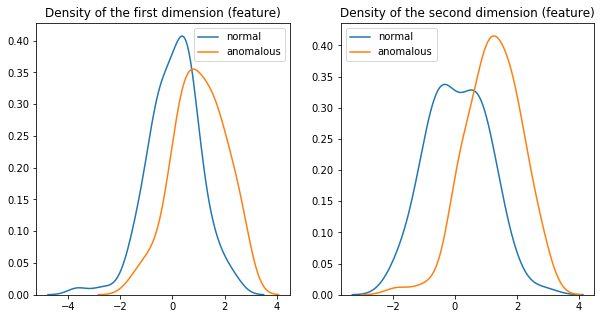

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (10,5))
plt.subplot(121)
sns.kdeplot(test_inputs[0,:], label = 'normal')
sns.kdeplot(test_inputs_anomaly[0,:], label = 'anomalous')
plt.title('Density of the first dimension (feature)')

plt.subplot(122)
sns.kdeplot(test_inputs[1,:], label = 'normal')
sns.kdeplot(test_inputs_anomaly[1,:], label = 'anomalous')
plt.title('Density of the second dimension (feature)')

# I have a mean shift in 30 dimensions, and the reconstruction loss is just 1.95. So we need a really
# sensitive threshold? 

I think there doesn't seem to be a probabilistic interpretation in this regard, because the output is real-valued. There is no guarantee whatsoever that we will end up with a probability? Can't use sigmoid either. But if that's the case, what is the probabilistic foundation of what we have just done?

I think a better way to see if the network is doing what it should is to produce data points that are certainly anomalous. Then shunt everything through the network, compute reconstruction 'probability' (which is MSE here) and see if it works or not. (Intuition - trivially it should work?)

See how the reconstruction loss changes when we change:
1. The number of neurons in the first layer
2. The number of latent variables
3. The number of features we have? I think 2. is a proxy for this already.